In [327]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.nn import functional as F
import math
import random

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

In [328]:
def FMNIST_dataset():
    train_data = FashionMNIST(root='../data', train=True, download=True, transform=ToTensor())
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)

    test_data = FashionMNIST(root='../data', train=False, download=True, transform=ToTensor())
    test_loader = DataLoader(test_data, batch_size=64, shuffle=True, drop_last=True)
    return train_loader, test_loader


def CIFAR10_dataset():
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
    train_set = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
    test_set = datasets.CIFAR10(root='../data', train=False,
                                download=True, transform=transform)
    
    batch_size = 64
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    return train_loader, test_loader


def Run(dataset, model, optimizer, criterion, EPOCHS):
    if dataset == 'CIFAR-10': train_loader, test_loader = CIFAR10_dataset()
    elif dataset == 'FMNIST': train_loader, test_loader = FMNIST_dataset()
    
    train_acc_list = []
    test_acc_list = []
    train_loss_list = []
    test_loss_list = []
    for epoch in range(EPOCHS):
        # Train
        model.train()
        train_loss = 0
        train_correct = 0
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, epoch)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (output.argmax(1) == target).sum().item()
            batch_acc = (output.argmax(1) == target).sum().item()/len(target)
            model.record_accuracy(epoch, batch_acc)
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        # Test
        model.eval()
        test_loss = 0
        test_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data, epoch)
                loss = criterion(output, target)
                test_loss += loss.item()
                test_correct += (output.argmax(1) == target).sum().item()
            test_loss /= len(test_loader.dataset)
            test_accuracy = test_correct / len(test_loader.dataset)
            test_acc_list.append(test_accuracy)
            test_loss_list.append(test_loss)
            
            
        
        # Show Result
        print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.4f} | Train Accuracy: {round(train_accuracy*100, 2)} | '
            f'Test Loss: {test_loss:.4f} | Test Accuracy: {round(test_accuracy*100, 2)}')
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list


def plot(method, dataset, exp_num, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save=False):
    figname = f"{method} ({dataset}) #{exp_num}.png"
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Test_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Test_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if save: plt.savefig(figname)
    plt.show()

In [329]:
class MyDrop(nn.Module):
    def __init__(self, p=0.5, total_epoch=10, k=1):
        super(MyDrop, self).__init__()
        self.p = p
        self.total_epoch = total_epoch
        self.masks = []
        self.accs = []
        self.k = k
        self.mask_idx = 0

    def forward(self, x, curr_epoch):
        if self.training:
            if curr_epoch <= (self.total_epoch/2):
                mask = (torch.rand_like(x) > self.p).float().to(device) 
                self.masks.append(mask)
                x = x * mask / (1 - self.p)
                x = x.to(device)
                return x
            elif curr_epoch > (self.total_epoch/2):
                topk_masks = sorted(list(enumerate(zip(self.masks, self.accs))), key=lambda x: x[1][1], reverse=True)[:self.k]
                self.mask_idx = random.choice(topk_masks)[0]
                mask = topk_masks[0][1][0]
                x = x * mask / (1 - self.p)
                return x
        
        elif not self.training:
            
            return x

    def record_acc(self, curr_epoch, accuracy):
        if curr_epoch <= (self.total_epoch/2):
            self.accs.append(accuracy)
        elif curr_epoch > (self.total_epoch/2):
            self.accs[self.mask_idx] = accuracy

In [330]:
curr_epoch  = 1
total_epoch = 2
dropout_prob = 0.5
top_k = 1

In [331]:
class Net_FMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 10)

        # Materials
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.edrop = MyDrop(p=dropout_prob, total_epoch=total_epoch, k=top_k)


    def forward(self, x, curr_epoch):
        # [64, 1, 28, 28]

        x = self.conv1(x)     
        x = self.bn1(x)       
        x = F.relu(x)          
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)     
        x = self.bn2(x)    
        x = F.relu(x)         
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.edrop(x, curr_epoch)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    
    def record_accuracy(self, curr_epoch, acc):
        self.edrop.record_acc(curr_epoch, acc)

In [332]:
# Run (FMNIST)
dataset = 'FMNIST'
FMNIST_EPOCHS = 100

model = Net_FMNIST().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(dataset, model, optimizer, criterion, FMNIST_EPOCHS)


Epoch  1 | Train Loss: 0.0097 | Train Accuracy: 82.8 | Test Loss: 0.0056 | Test Accuracy: 87.13
Epoch  2 | Train Loss: 0.0054 | Train Accuracy: 88.32 | Test Loss: 0.0051 | Test Accuracy: 88.18
Epoch  3 | Train Loss: 0.0045 | Train Accuracy: 89.94 | Test Loss: 0.0042 | Test Accuracy: 89.93
Epoch  4 | Train Loss: 0.0041 | Train Accuracy: 90.66 | Test Loss: 0.0049 | Test Accuracy: 88.0
Epoch  5 | Train Loss: 0.0038 | Train Accuracy: 91.27 | Test Loss: 0.0041 | Test Accuracy: 90.31
Epoch  6 | Train Loss: 0.0035 | Train Accuracy: 91.87 | Test Loss: 0.0041 | Test Accuracy: 90.14
Epoch  7 | Train Loss: 0.0033 | Train Accuracy: 92.33 | Test Loss: 0.0040 | Test Accuracy: 90.49
Epoch  8 | Train Loss: 0.0032 | Train Accuracy: 92.63 | Test Loss: 0.0039 | Test Accuracy: 90.8
Epoch  9 | Train Loss: 0.0030 | Train Accuracy: 93.02 | Test Loss: 0.0037 | Test Accuracy: 91.32
Epoch 10 | Train Loss: 0.0028 | Train Accuracy: 93.42 | Test Loss: 0.0038 | Test Accuracy: 90.87
Epoch 11 | Train Loss: 0.0027 | T

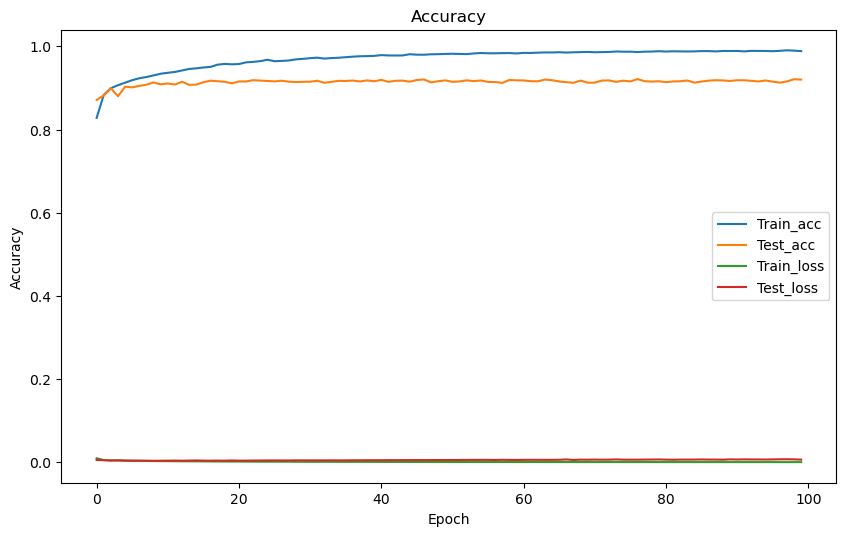

In [334]:
method = 'Shape-Memory Dropout (Only training)'
dataset = 'FMNIST'
exp_num = '0'
save = False
plot(method, dataset, exp_num, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save)